# Imports

In [3]:
import os
import random
import platform
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet50
import torchvision.transforms.functional as TF
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Device Configuration

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Enable synchronous CUDA for better error reporting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if str(device) == "cuda:0":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cpu


# Load CSV and prepare dataset splits

In [8]:
csv_path = '../data/processed/splits/split_mapping.csv'
stacked_data_path = '../data/processed/stacked'
output_dir = '../output/deep_learning'
output_suffix = '_final.csv'

print("Loading pre-split CSV file...")
df = pd.read_csv(csv_path)
print(f"Total samples: {len(df)}")

# The CSV already has a 'class' column, but let's also extract from filename as backup
df['class_from_filename'] = df['output_file'].str.extract(r'_class(\d+)\.npy')[0]

# Use the class column from CSV, fallback to filename extraction, and handle NaN
df['class'] = df['class'].fillna(df['class_from_filename']).fillna(-1).astype(int)

# Filter out samples without class labels (class == -1 or NaN)
labeled_samples = df[df['class'] >= 0].copy()
print(f"Samples with labels: {len(labeled_samples)}")

print("Columns in CSV:", df.columns.tolist())
print("First few rows:")
print(df.head())

print("\nClass distribution:")
print(labeled_samples['class'].value_counts().sort_index())

Loading pre-split CSV file...
Total samples: 6807
Samples with labels: 5743
Columns in CSV: ['output_file', 'class', 'patch_id', 'dates', 'input_files', 'shape', 'temporal_samples', 'zone_id', 'crop_type', 'split', 'class_from_filename']
First few rows:
        output_file  class  patch_id                         dates  \
0  10000_class3.npy      3     10000  ['2023-06-28', '2023-07-07']   
1  10001_class3.npy      3     10001  ['2023-06-28', '2023-07-07']   
2  10002_class3.npy      3     10002  ['2023-06-28', '2023-07-07']   
3  10003_class3.npy      3     10003  ['2023-06-28', '2023-07-07']   
4         10004.npy     -1     10004  ['2023-06-28', '2023-07-07']   

                                         input_files         shape  \
0  ['data/processed/patches\\230628_reflectance_o...  [20, 64, 64]   
1  ['data/processed/patches\\230628_reflectance_o...  [20, 64, 64]   
2  ['data/processed/patches\\230628_reflectance_o...  [20, 64, 64]   
3  ['data/processed/patches\\230628_reflectan

C:\Users\pinhe\AppData\Local\Temp\ipykernel_24528\2826962156.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].fillna(df['class_from_filename']).fillna(-1).astype(int)


# Custom Dataset

In [9]:
class CropDatasetFromCSV(Dataset):
    """
    Custom Dataset for loading multi-band .npy images from a CSV file.

    CSV file must contain:
    - 'filename': path to .npy file (relative to image_dir)
    - 'label': integer class label
    """
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Validate and fix labels
        print(f"Original label range: {self.data['label'].min()} to {self.data['label'].max()}")
        min_label = self.data['label'].min()
        if min_label < 0:
            print(f"Warning: Found negative labels (min: {min_label}). Adjusting...")
            self.data['label'] = self.data['label'] - min_label

        self.num_classes = self.data['label'].nunique()
        max_label = self.data['label'].max()

        print(f"Adjusted label range: {self.data['label'].min()} to {max_label}")
        print(f"Number of unique classes: {self.num_classes}")
        print(f"Unique labels: {sorted(self.data['label'].unique())}")

        unique_labels = sorted(self.data['label'].unique())
        if unique_labels != list(range(len(unique_labels))):
            print("Warning: Labels are not continuous. Remapping...")
            label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
            self.data['label'] = self.data['label'].map(label_mapping)
            print(f"Remapped labels: {sorted(self.data['label'].unique())}")

        # Final validation
        assert self.data['label'].min() >= 0, "Labels must be non-negative"
        assert self.data['label'].max() < self.num_classes, f"Labels must be < {self.num_classes}"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            filename = self.data.iloc[idx]['filename']
            label = self.data.iloc[idx]['label']

            # Validate label range
            if label < 0 or label >= self.num_classes:
                print(f"Warning: Invalid label {label} at index {idx}. Clamping to valid range.")
                label = max(0, min(label, self.num_classes - 1))

            label = torch.tensor(label, dtype=torch.long)

            # Load .npy image
            path = os.path.join(self.image_dir, filename)
            array = np.load(path)  # Shape: [Bands, H, W]

            # Replace NaN/Inf values
            array = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)

            tensor = torch.tensor(array, dtype=torch.float32)

            # Apply transform if defined
            if self.transform:
                tensor = self.transform(tensor)

            return tensor, label
        except Exception as e:
            print(f"Error loading file {filename} at index {idx}: {e}")
            dummy_tensor = torch.zeros(100, 64, 64, dtype=torch.float32)
            dummy_label = torch.tensor(0, dtype=torch.long)
            return dummy_tensor, dummy_label

# Custom Transform

In [10]:
class MultiBandTransform:
    """
    Transformation for multi-band images:
    - Resize to target size
    - Random flips and rotations
    - Optional per-band min-max normalization
    """
    def __init__(self, size=224, normalize=False):
        self.size = size
        self.normalize = normalize

    def __call__(self, x):
        # Resize to target size
        x = F.interpolate(x.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False)
        x = x.squeeze(0)

        # Random flips and rotation
        if random.random() > 0.5:
            x = TF.hflip(x)
        if random.random() > 0.5:
            x = TF.vflip(x)
        if random.random() > 0.5:
            x = TF.rotate(x, angle=90)

        # Optional normalization
        if self.normalize:
            min_vals = x.amin(dim=(1, 2), keepdim=True)
            max_vals = x.amax(dim=(1, 2), keepdim=True)
            x = (x - min_vals) / (max_vals - min_vals + 1e-6)

        return x

# **Dataloader**

In [12]:
# Create datasets using our existing split_mapping.csv and labeled_samples
import os

# Use the data from the previous cell
print("=== Creating datasets from existing data ===")

# Create separate DataFrames for each split
train_df = labeled_samples[labeled_samples['split'] == 'train'].copy()
val_df = labeled_samples[labeled_samples['split'] == 'val'].copy() 
test_df = labeled_samples[labeled_samples['split'] == 'test'].copy()

print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Create temporary CSV files for the dataset class
os.makedirs('../temp', exist_ok=True)

train_df_subset = train_df[['output_file', 'class']].rename(columns={'output_file': 'filename', 'class': 'label'})
val_df_subset = val_df[['output_file', 'class']].rename(columns={'output_file': 'filename', 'class': 'label'})
test_df_subset = test_df[['output_file', 'class']].rename(columns={'output_file': 'filename', 'class': 'label'})

train_csv_temp = '../temp/train.csv'
val_csv_temp = '../temp/val.csv'
test_csv_temp = '../temp/test.csv'

train_df_subset.to_csv(train_csv_temp, index=False)
val_df_subset.to_csv(val_csv_temp, index=False)
test_df_subset.to_csv(test_csv_temp, index=False)

# Set up transforms
train_transform = MultiBandTransform(size=64, normalize=True)
val_transform = MultiBandTransform(size=64, normalize=True)

print("=== Creating datasets with label validation ===")
train_dataset = CropDatasetFromCSV(train_csv_temp, stacked_data_path, transform=train_transform)
val_dataset = CropDatasetFromCSV(val_csv_temp, stacked_data_path, transform=val_transform)
test_dataset = CropDatasetFromCSV(test_csv_temp, stacked_data_path, transform=val_transform)

print("\nDataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Number of classes (train): {train_dataset.num_classes}")
print(f"Number of classes (val): {val_dataset.num_classes}")
print(f"Number of classes (test): {test_dataset.num_classes}")

assert train_dataset.num_classes == val_dataset.num_classes == test_dataset.num_classes, \
    "All datasets must have the same number of classes"

num_workers = 0 if platform.system() == 'Windows' else 2
print(f"Using num_workers={num_workers} for DataLoader")

try:
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=False)
    print("DataLoaders created successfully.")
except Exception as e:
    print(f"Error creating DataLoaders with num_workers={num_workers}, falling back to num_workers=0")
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    print("DataLoaders created with num_workers=0.")

print("=== Dataset creation complete ===")

# Example batch
batch = next(iter(train_loader))
images, labels = batch
print("Batch shape:", images.shape)
print("Batch values (min, max):", images.min().item(), images.max().item())
print("Label range:", labels.min().item(), "to", labels.max().item())

=== Creating datasets from existing data ===
Train samples: 2900
Val samples: 1412
Test samples: 1431
=== Creating datasets with label validation ===
Original label range: 3 to 7
Adjusted label range: 3 to 7
Number of unique classes: 5
Unique labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Remapped labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Original label range: 3 to 7
Adjusted label range: 3 to 7
Number of unique classes: 5
Unique labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Remapped labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Original label range: 3 to 7
Adjusted label range: 3 to 7
Number of unique classes: 5
Unique labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Remapped labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Dataset sizes:
Train: 2900
Val: 1412
Test: 1431
Number of classes (train): 5
Number of classes (val

# **Data augmentation visualization**

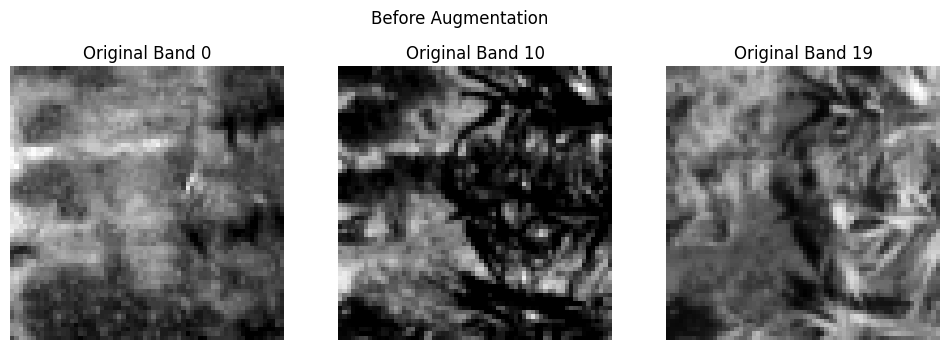

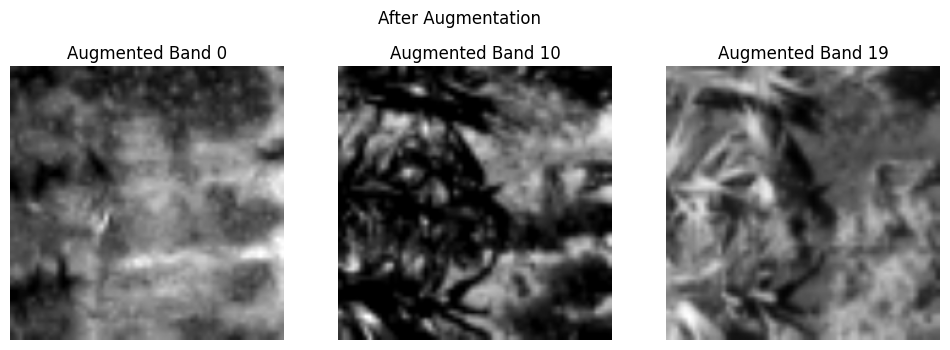

In [15]:
transform_aug = MultiBandTransform(size=224, normalize=False)

plt.figure(figsize=(12, 4))
for i, band in enumerate([0, 10, 19]):  # Valid band indices for 20-band data
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[0][band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Augmentation')
plt.show()

sample_aug = transform_aug(images[0])

plt.figure(figsize=(12, 4))
for i, band in enumerate([0, 10, 19]):  # Valid band indices for 20-band data
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample_aug[band], cmap='gray')
    plt.title(f'Augmented Band {band}')
    plt.axis('off')
plt.suptitle('After Augmentation')
plt.show()

# ResNet50

Creating model on CPU due to CUDA context corruption.
To fix CUDA issues: restart the kernel and rerun all cells.
Device: cpu
Creating model with 5 classes and 20 input channels.
Model created successfully with 5 output classes.
Model input channels: 20
Model output classes: 5

IMPORTANT: To use CUDA again:
1. Restart the kernel
2. Rerun all cells from the beginning
3. Change device back to 'cuda' in training configuration
Image batch shape: torch.Size([16, 20, 64, 64])
Label batch shape: torch.Size([16])
Example label: tensor(2)
=== LABEL DEBUGGING ===
Model created successfully with 5 output classes.
Model input channels: 20
Model output classes: 5

IMPORTANT: To use CUDA again:
1. Restart the kernel
2. Rerun all cells from the beginning
3. Change device back to 'cuda' in training configuration
Image batch shape: torch.Size([16, 20, 64, 64])
Label batch shape: torch.Size([16])
Example label: tensor(2)
=== LABEL DEBUGGING ===
Training labels range: 2 to 4
Unique training labels: [2, 4

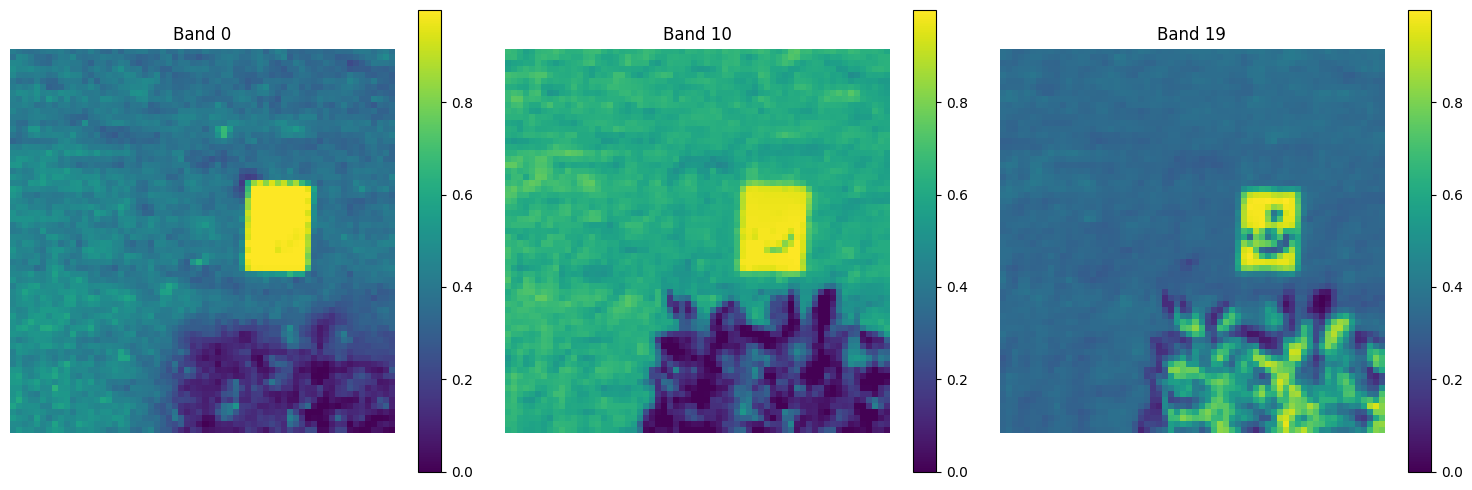

In [16]:
# Model definition and training pipeline
# Note: Using CPU due to CUDA context corruption. To enable GPU, restart the kernel.

print("Creating model on CPU due to CUDA context corruption.")
print("To fix CUDA issues: restart the kernel and rerun all cells.")

class CustomResNet50(nn.Module):
    """
    Custom ResNet-50 model with adjustable input channels and number of classes.
    """
    def __init__(self, in_channels=20, num_classes=5):
        super().__init__()
        self.model = resnet50(weights=None)

        # Replace first convolutional layer for multi-band input
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace classification head
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Instantiate model
num_classes = train_dataset.num_classes
num_channels = train_dataset[0][0].shape[0]  # Get number of channels from first sample
print(f"Creating model with {num_classes} classes and {num_channels} input channels.")
model = CustomResNet50(in_channels=num_channels, num_classes=num_classes).to(device)
print(f"Model created successfully with {num_classes} output classes.")
print(f"Model input channels: {model.model.conv1.in_channels}")
print(f"Model output classes: {model.model.fc.out_features}")

print("\nIMPORTANT: To use CUDA again:")
print("1. Restart the kernel")
print("2. Rerun all cells from the beginning")
print("3. Change device back to 'cuda' in training configuration")


# Inspect one batch of data
batch = next(iter(train_loader))
images, labels = batch
print("Image batch shape:", images.shape)   # e.g. [16, 20, 64, 64]
print("Label batch shape:", labels.shape)
print("Example label:", labels[0])

print("=== LABEL DEBUGGING ===")
all_train_labels = [train_dataset[i][1].item() for i in range(min(100, len(train_dataset)))]
print(f"Training labels range: {min(all_train_labels)} to {max(all_train_labels)}")
print(f"Unique training labels: {sorted(set(all_train_labels))}")
print(f"Expected range for {train_dataset.num_classes} classes: 0 to {train_dataset.num_classes-1}")

valid_labels = [l for l in all_train_labels if 0 <= l < train_dataset.num_classes]
invalid_labels = [l for l in all_train_labels if l < 0 or l >= train_dataset.num_classes]
print(f"Valid labels count: {len(valid_labels)}")
print(f"Invalid labels: {invalid_labels}")

if invalid_labels:
    print("WARNING: Invalid labels detected! Labels must be in range [0, num_classes-1].")
else:
    print("All training labels are valid.")

# Validation label check
all_val_labels = [val_dataset[i][1].item() for i in range(min(200, len(val_dataset)))]
print(f"Validation labels range: {min(all_val_labels)} to {max(all_val_labels)}")
print(f"Unique validation labels: {sorted(set(all_val_labels))}")
print("=== END LABEL DEBUGGING ===\n")


# Visualize selected image bands
img = images[0]
plt.figure(figsize=(15, 5))
for i, band_idx in enumerate([0, 10, 19]):  # Select first, middle, and last bands
    plt.subplot(1, 3, i+1)
    plt.imshow(img[band_idx].cpu().numpy(), cmap="viridis")
    plt.title(f"Band {band_idx}")
    plt.axis("off")
    plt.colorbar()
plt.tight_layout()
plt.show()

# **Trainings Loop**

In [21]:
def training_settings_with_tensorboard(model, epochs, device, optimizer,
                                       criterion, train_dataloader, val_dataloader,
                                       weights_name, log_dir="runs", weights_dir="model_weights",
                                       run_name=None, writer=None):
    """
    Train and validate a model with TensorBoard logging.
    Logs include loss, accuracy, and F1 score for both training and validation.

    Args:
        model (nn.Module): Model to train.
        epochs (int): Number of training epochs.
        device (str): Device ('cpu' or 'cuda').
        optimizer (torch.optim.Optimizer): Optimizer.
        criterion: Loss function.
        train_dataloader (DataLoader): Training data loader.
        val_dataloader (DataLoader): Validation data loader.
        weights_name (str): Base filename for saving weights.
        log_dir (str): Directory for TensorBoard logs.
        weights_dir (str): Directory for saving model weights.
        run_name (str): Optional run identifier for logs.
        writer (SummaryWriter): Optional shared SummaryWriter.

    Returns:
        tuple: Lists of train_losses, val_losses, train_accuracy,
               val_accuracy, train_f1_scores, val_f1_scores
    """
    # Create directories if they don't exist
    import os
    os.makedirs(weights_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    
    own_writer = writer is None
    if own_writer:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_path = f"{log_dir}/{run_name}_{timestamp}" if run_name else f"{log_dir}/crop_classification_{timestamp}"
        writer = SummaryWriter(log_path)
    else:
        log_path = writer.log_dir

    train_losses, val_losses = [], []
    trn_accuracy, val_accuracy = [], []
    train_f1_scores, val_f1_scores = [], []

    num_classes = model.model.fc.out_features
    print(f"Model expects {num_classes} classes.")

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_predictions, train_true_labels = [], []

        for batch_idx, (images, labels) in enumerate(train_dataloader):
            try:
                images, labels = images.to(device), labels.to(device)
                labels = labels.long()  # Ensure labels are long tensors

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                if torch.isnan(loss):
                    print(f"NaN training loss at epoch {epoch}, batch {batch_idx}. Skipping batch.")
                    continue

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_predictions.extend(predicted.cpu().numpy())
                train_true_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                print(f"RuntimeError in training (epoch {epoch}, batch {batch_idx}): {e}")
                raise e

        if train_total > 0:
            train_loss /= len(train_dataloader)
            train_acc = 100.0 * train_correct / train_total
            train_f1 = f1_score(train_true_labels, train_predictions, average="weighted") * 100
            train_losses.append(train_loss)
            trn_accuracy.append(train_acc)
            train_f1_scores.append(train_f1)
        else:
            print(f"No valid training samples in epoch {epoch}.")
            continue

        # Validation Phase
        model.eval()
        valid_loss, valid_correct, valid_total = 0.0, 0, 0
        val_predictions, val_true_labels = [], []
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_dataloader):
                try:
                    images, labels = images.to(device), labels.to(device)
                    labels = labels.long()

                    outputs = model(images)
                    loss = criterion(outputs, labels.long())
                    if torch.isnan(loss):
                        print(f"NaN validation loss at epoch {epoch}, batch {batch_idx}. Skipping batch.")
                        continue

                    valid_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    valid_total += labels.size(0)
                    valid_correct += (predicted == labels).sum().item()
                    val_predictions.extend(predicted.cpu().numpy())
                    val_true_labels.extend(labels.cpu().numpy())
                except RuntimeError as e:
                    print(f"RuntimeError in validation (epoch {epoch}, batch {batch_idx}): {e}")
                    raise e

        if valid_total > 0:
            valid_loss /= len(val_dataloader)
            val_acc = 100.0 * valid_correct / valid_total
            val_f1 = f1_score(val_true_labels, val_predictions, average="weighted") * 100
            val_losses.append(valid_loss)
            val_accuracy.append(val_acc)
            val_f1_scores.append(val_f1)
        else:
            print(f"No valid validation samples in epoch {epoch}.")
            continue

        # === Logging ===
        tag_prefix = f"{run_name}/" if run_name and not own_writer else ""
        writer.add_scalar(f"{tag_prefix}Loss/Train_Epoch", train_loss, epoch)
        writer.add_scalar(f"{tag_prefix}Loss/Validation_Epoch", valid_loss, epoch)
        writer.add_scalar(f"{tag_prefix}Accuracy/Train", train_acc, epoch)
        writer.add_scalar(f"{tag_prefix}Accuracy/Validation", val_acc, epoch)
        writer.add_scalar(f"{tag_prefix}F1_Score/Train", train_f1, epoch)
        writer.add_scalar(f"{tag_prefix}F1_Score/Validation", val_f1, epoch)
        writer.add_scalar(f"{tag_prefix}Learning_Rate", optimizer.param_groups[0]["lr"], epoch)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, F1: {train_f1:.2f}% | "
              f"Val Loss: {valid_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.2f}%")

        torch.save(model.state_dict(), f"{weights_dir}/{weights_name}_epoch_{epoch}.pt")

    if own_writer:
        writer.close()
        print(f"TensorBoard logs saved to: {log_path}")
    else:
        print("Metrics logged to shared writer.")

    return train_losses, val_losses, trn_accuracy, val_accuracy, train_f1_scores, val_f1_scores

# Single Training

In [18]:
model_weights_name = "best_model_weights_v2"
current_device = next(model.parameters()).device  # Get device from model
print(f"Training will run on: {current_device}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 15  # Reduced for CPU training

print("=== PRE-TRAINING VALIDATION ===")
print(f"Model device: {current_device}")
print(f"Model output classes: {model.model.fc.out_features}")
print(f"Training dataset classes: {train_dataset.num_classes}")
print(f"Validation dataset classes: {val_dataset.num_classes}")

# Verify model and data compatibility
if model.model.fc.out_features == train_dataset.num_classes:
    print("Model and dataset classes match!")
else:
    print(f"ERROR: Model expects {model.model.fc.out_features} "
          f"classes but dataset has {train_dataset.num_classes}")

print("=== READY TO START TRAINING ===")
print("Training on CPU will be slower than GPU")
print("To use GPU: Restart kernel and rerun all cells")


Training will run on: cpu
=== PRE-TRAINING VALIDATION ===
Model device: cpu
Model output classes: 5
Training dataset classes: 5
Validation dataset classes: 5
Model and dataset classes match!
=== READY TO START TRAINING ===
Training on CPU will be slower than GPU
To use GPU: Restart kernel and rerun all cells


In [22]:
# Ensure directories exist and check device configuration
import os

# Create required directories
os.makedirs("model_weights", exist_ok=True)
os.makedirs("tensorboard_logs", exist_ok=True)
print("Created directories: model_weights, tensorboard_logs")

# Check device configuration
print(f"Current device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
current_device = device  # Use the device from the model setup
print(f"Using device for training: {current_device}")

# Verify model is on correct device
print(f"Model device: {next(model.parameters()).device}")

print("Ready for training!")

Created directories: model_weights, tensorboard_logs
Current device: cpu
CUDA available: False
Using device for training: cpu
Model device: cpu
Ready for training!


Start Training

Model expects 5 classes.
Epoch [1/15] Train Loss: 0.8754, Acc: 66.31%, F1: 65.82% | Val Loss: 0.5349, Acc: 81.44%, F1: 81.20%
Epoch [1/15] Train Loss: 0.8754, Acc: 66.31%, F1: 65.82% | Val Loss: 0.5349, Acc: 81.44%, F1: 81.20%
Epoch [2/15] Train Loss: 0.7122, Acc: 73.21%, F1: 73.00% | Val Loss: 0.5197, Acc: 81.80%, F1: 80.90%
Epoch [2/15] Train Loss: 0.7122, Acc: 73.21%, F1: 73.00% | Val Loss: 0.5197, Acc: 81.80%, F1: 80.90%
Epoch [3/15] Train Loss: 0.6148, Acc: 77.24%, F1: 77.09% | Val Loss: 0.4736, Acc: 83.64%, F1: 83.71%
Epoch [3/15] Train Loss: 0.6148, Acc: 77.24%, F1: 77.09% | Val Loss: 0.4736, Acc: 83.64%, F1: 83.71%
Epoch [4/15] Train Loss: 0.5364, Acc: 80.31%, F1: 80.17% | Val Loss: 0.3448, Acc: 87.96%, F1: 87.99%
Epoch [4/15] Train Loss: 0.5364, Acc: 80.31%, F1: 80.17% | Val Loss: 0.3448, Acc: 87.96%, F1: 87.99%
Epoch [5/15] Train Loss: 0.5073, Acc: 81.10%, F1: 81.03% | Val Loss: 0.2930, Acc: 90.01%, F1: 90.04%
Epoch [5/15] Train Loss: 0.5073, Acc: 81.10%, F1: 81.03% | Val Los

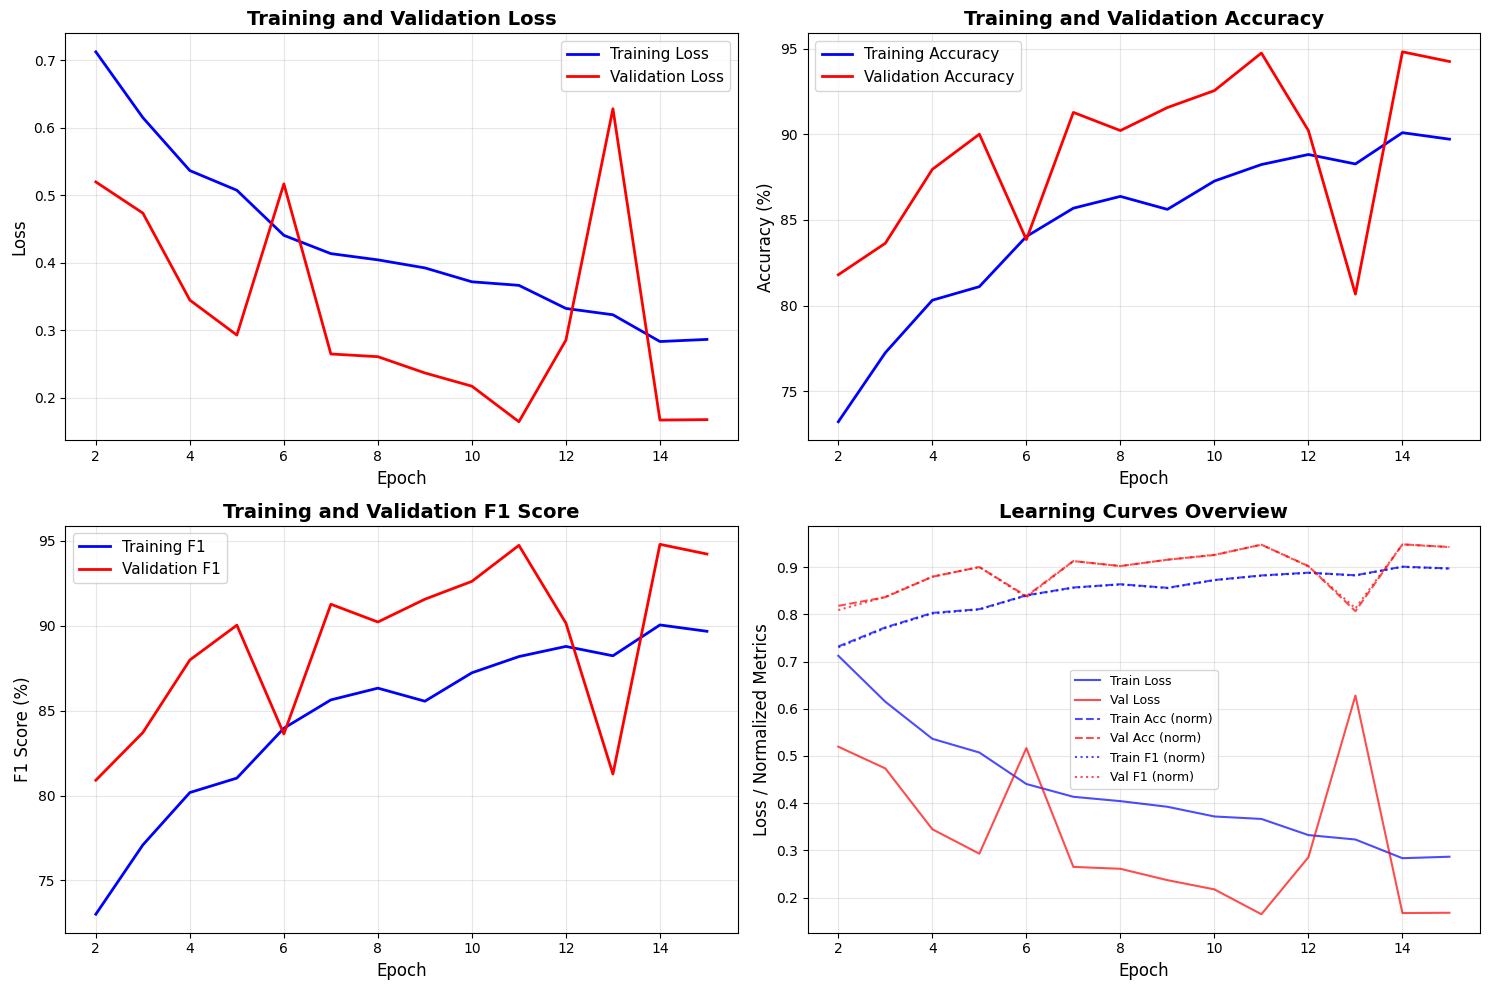


Final Training Results:
Training Loss: 0.2866
Validation Loss: 0.1679
Training Accuracy: 89.72%
Validation Accuracy: 94.26%
Training F1 Score: 89.68%
Validation F1 Score: 94.23%


In [23]:
train_losses, val_losses, train_acc, val_acc, train_f1_scores, val_f1_scores = training_settings_with_tensorboard(
    model=model,
    epochs=epochs,
    device=current_device,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    weights_name=model_weights_name,
    log_dir="tensorboard_logs"
)


# Training Progress Visualization

plt.figure(figsize=(15, 10))

# Slice from index 1 to skip epoch 0
train_losses_plot = train_losses[1:] if len(train_losses) > 1 else train_losses
val_losses_plot = val_losses[1:] if len(val_losses) > 1 else val_losses
train_acc_plot = train_acc[1:] if len(train_acc) > 1 else train_acc
val_acc_plot = val_acc[1:] if len(val_acc) > 1 else val_acc
train_f1_plot = train_f1_scores[1:] if len(train_f1_scores) > 1 else train_f1_scores
val_f1_plot = val_f1_scores[1:] if len(val_f1_scores) > 1 else val_f1_scores

# Plot 1: Loss curves
plt.subplot(2, 2, 1)
plt.plot(range(2, len(train_losses) + 1), train_losses_plot, "b-", label="Training Loss", linewidth=2)
plt.plot(range(2, len(val_losses) + 1), val_losses_plot, "r-", label="Validation Loss", linewidth=2)
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
plt.subplot(2, 2, 2)
plt.plot(range(2, len(train_acc) + 1), train_acc_plot, "b-", label="Training Accuracy", linewidth=2)
plt.plot(range(2, len(val_acc) + 1), val_acc_plot, "r-", label="Validation Accuracy", linewidth=2)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 3: F1 Score curves
plt.subplot(2, 2, 3)
plt.plot(range(2, len(train_f1_scores) + 1), train_f1_plot, "b-", label="Training F1", linewidth=2)
plt.plot(range(2, len(val_f1_scores) + 1), val_f1_plot, "r-", label="Validation F1", linewidth=2)
plt.title("Training and Validation F1 Score", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("F1 Score (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 4: Overview
plt.subplot(2, 2, 4)
epochs_range = range(2, len(train_losses) + 1)
plt.plot(epochs_range, train_losses_plot, "b-", alpha=0.7, label="Train Loss")
plt.plot(epochs_range, val_losses_plot, "r-", alpha=0.7, label="Val Loss")

# Normalize accuracy/F1 to same scale as loss
norm_train_acc = [acc / 100 for acc in train_acc_plot]
norm_val_acc = [acc / 100 for acc in val_acc_plot]
norm_train_f1 = [f1 / 100 for f1 in train_f1_plot]
norm_val_f1 = [f1 / 100 for f1 in val_f1_plot]

plt.plot(epochs_range, norm_train_acc, "b--", alpha=0.7, label="Train Acc (norm)")
plt.plot(epochs_range, norm_val_acc, "r--", alpha=0.7, label="Val Acc (norm)")
plt.plot(epochs_range, norm_train_f1, "b:", alpha=0.7, label="Train F1 (norm)")
plt.plot(epochs_range, norm_val_f1, "r:", alpha=0.7, label="Val F1 (norm)")
plt.title("Learning Curves Overview", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss / Normalized Metrics", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Training Stats

print("\nFinal Training Results:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Validation Accuracy: {val_acc[-1]:.2f}%")
print(f"Training F1 Score: {train_f1_scores[-1]:.2f}%")
print(f"Validation F1 Score: {val_f1_scores[-1]:.2f}%")

# **Hyperparameters**

In [25]:
from itertools import product
import json
import pandas as pd
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

def simple_hyperparameter_search(
    train_loader, val_loader, test_loader, param_grid,
    device="cpu", results_file="hyperparameter_results.json"
):
    """
    Perform hyperparameter tuning using simple grid search with existing train/val split.

    Args:
        train_loader (DataLoader): Training DataLoader
        val_loader (DataLoader): Validation DataLoader
        test_loader (DataLoader): Test DataLoader
        param_grid (dict): Dictionary of hyperparameters to search
        device (str): Device to run on
        results_file (str): File to save results

    Returns:
        best_params (dict): Best hyperparameter combination
        all_results (list): All experiment results
    """
    print("="*80)
    print("HYPERPARAMETER TUNING WITH GRID SEARCH")
    print("="*80)

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))

    print(f"Parameter grid: {param_grid}")
    print(f"Total combinations: {len(param_combinations)}")

    # Create shared TensorBoard writer
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    shared_log_dir = f"tensorboard_logs/hyperparameter_search_{timestamp}"
    shared_writer = SummaryWriter(shared_log_dir)
    print(f"Shared TensorBoard logs: {shared_log_dir}")

    all_results = []
    best_score = -1
    best_params = None

    # Evaluate all parameter combinations
    for param_idx, param_combo in enumerate(param_combinations):
        current_params = dict(zip(param_names, param_combo))
        print(f"\n{'='*60}")
        print(f"Testing combination {param_idx + 1}/{len(param_combinations)}: {current_params}")
        print(f"{'='*60}")

        try:
            # Initialize model
            model = CustomResNet50().to(device)

            # Setup optimizer
            if current_params["optimizer"] == "adam":
                optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=current_params["learning_rate"],
                    weight_decay=current_params.get("weight_decay", 0)
                )
            elif current_params["optimizer"] == "sgd":
                optimizer = torch.optim.SGD(
                    model.parameters(),
                    lr=current_params["learning_rate"],
                    momentum=current_params.get("momentum", 0.9),
                    weight_decay=current_params.get("weight_decay", 0)
                )
            criterion = nn.CrossEntropyLoss()

            # Adjust batch size if needed
            if current_params["batch_size"] != train_loader.batch_size:
                current_train_loader = DataLoader(
                    train_loader.dataset,
                    batch_size=current_params["batch_size"],
                    shuffle=True
                )
                current_val_loader = DataLoader(
                    val_loader.dataset,
                    batch_size=current_params["batch_size"],
                    shuffle=False
                )
            else:
                current_train_loader = train_loader
                current_val_loader = val_loader

            # Define run name
            run_name = (
                f"hparam_{param_idx}_lr{current_params['learning_rate']}_"
                f"bs{current_params['batch_size']}_opt{current_params['optimizer']}_"
                f"ep{current_params['epochs']}"
            )

            # Train model
            train_losses, val_losses, train_acc, val_acc, train_f1, val_f1 = training_settings_with_tensorboard(
                model=model,
                epochs=current_params["epochs"],
                device=device,
                optimizer=optimizer,
                criterion=criterion,
                train_dataloader=current_train_loader,
                val_dataloader=current_val_loader,
                weights_name=f"hyperparam_search_{param_idx}",
                run_name=run_name,
                writer=shared_writer
            )

            # Collect results
            result = {
                "params": current_params,
                "final_train_loss": train_losses[-1] if train_losses else float("inf"),
                "final_val_loss": val_losses[-1] if val_losses else float("inf"),
                "final_train_acc": train_acc[-1] if train_acc else 0,
                "final_val_acc": val_acc[-1] if val_acc else 0,
                "final_train_f1": train_f1[-1] if train_f1 else 0,
                "final_val_f1": val_f1[-1] if val_f1 else 0,
                "max_val_acc": max(val_acc) if val_acc else 0,
                "max_val_f1": max(val_f1) if val_f1 else 0,
                "score": max(val_acc) if val_acc else 0
            }
            all_results.append(result)

            # Track best parameters
            if result["score"] > best_score:
                best_score = result["score"]
                best_params = current_params.copy()
                print(f"New best parameters found. Score: {best_score:.2f}%")

            # Save intermediate results
            with open(results_file, "w") as f:
                json.dump({
                    "best_params": best_params,
                    "best_score": best_score,
                    "all_results": [
                        {k: v for k, v in r.items() if k not in [
                            "train_losses", "val_losses", "train_acc", "val_acc", "train_f1", "val_f1"
                        ]}
                        for r in all_results
                    ]
                }, f, indent=2)

        except Exception as e:
            print(f"Error in experiment {param_idx + 1}: {e}")
            import traceback
            traceback.print_exc()
            all_results.append({"params": current_params, "error": str(e), "score": 0})

    # Final reporting
    all_results.sort(key=lambda x: x.get("score", 0), reverse=True)

    print("\n" + "="*80)
    print("HYPERPARAMETER TUNING COMPLETE")
    print("="*80)
    print(f"Best Parameters: {best_params}")
    print(f"Best Score: {best_score:.2f}%")

    shared_writer.close()
    print(f"TensorBoard writer closed. Logs available at {shared_log_dir}")

    return best_params, all_results

# Hyperparameter Grid Definition

In [ ]:
hyperparameter_grid = {
    "learning_rate": [0.0001, 0.0005],
    "batch_size": [16, 32],
    "optimizer": ["adam"],
    "weight_decay": [0.001],
    "epochs": [20, 30, 50],
}

print("Hyperparameter Grid:")
for param, values in hyperparameter_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in hyperparameter_grid.values():
    total_combinations *= len(values)
print(f"Total combinations to test: {total_combinations}")

# Hyperparameter Search

In [ ]:
try:
    best_params, all_results = simple_hyperparameter_search(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=hyperparameter_grid,
        device="cuda:0",
        results_file="simple_hyperparameter_results.json"
    )
    print("Hyperparameter tuning completed successfully.")
    print(f"Best parameters: {best_params}")
except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")
    import traceback
    traceback.print_exc()

# Confusion Matrix

In [26]:
# Test Set Evaluation
print("="*60)
print("EVALUATING TRAINED MODEL ON TEST SET")
print("="*60)

# Set model to evaluation mode
model.eval()

# Initialize lists for predictions and true labels
predictions = []
true_labels = []
test_loss = 0.0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Store predictions and true labels
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = 100.0 * sum(p == t for p, t in zip(predictions, true_labels)) / len(true_labels)
test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Total Test Samples: {len(true_labels)}")

# Convert to numpy arrays for easier handling
import numpy as np
true_labels = np.array(true_labels)
predictions = np.array(predictions)

print(f"Unique classes in test set: {np.unique(true_labels)}")
print(f"Test set class distribution:")
for class_id in np.unique(true_labels):
    count = np.sum(true_labels == class_id)
    percentage = 100.0 * count / len(true_labels)
    print(f"  Class {class_id}: {count} samples ({percentage:.1f}%)")

print("Test evaluation completed!")

EVALUATING TRAINED MODEL ON TEST SET
Test Loss: 0.7188
Test Accuracy: 88.82%
Total Test Samples: 1431
Unique classes in test set: [0 1 2 3 4]
Test set class distribution:
  Class 0: 317 samples (22.2%)
  Class 1: 158 samples (11.0%)
  Class 2: 320 samples (22.4%)
  Class 3: 320 samples (22.4%)
  Class 4: 316 samples (22.1%)
Test evaluation completed!


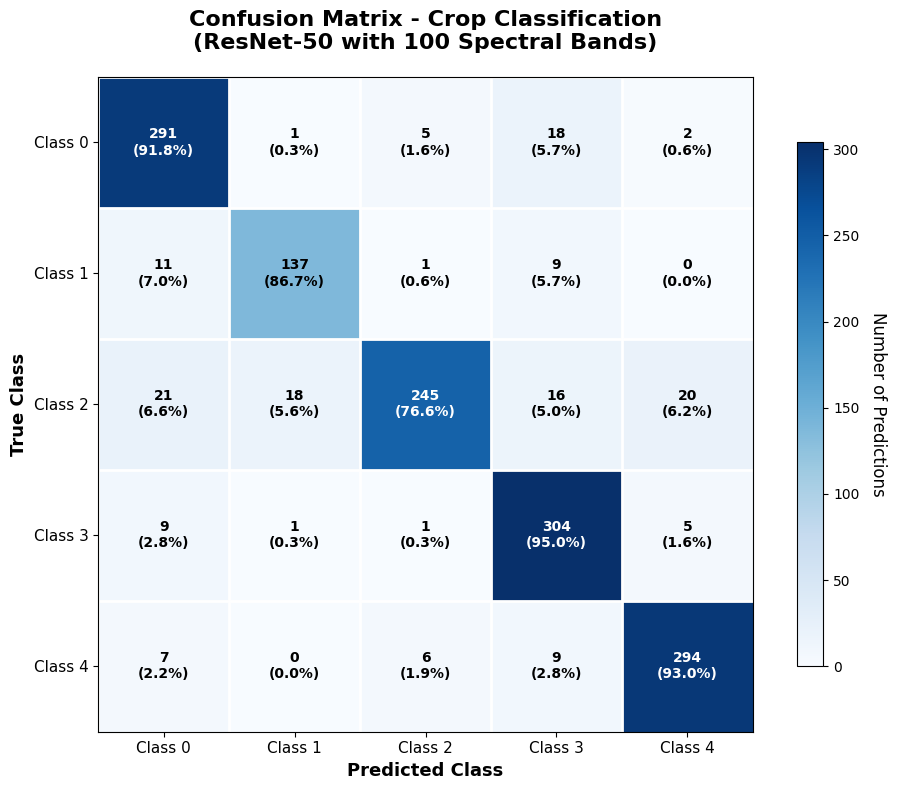

DETAILED CLASSIFICATION REPORT
Total Test Samples: 1431
Correct Predictions: 1271
Incorrect Predictions: 160


In [27]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Create visualization
plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Number of Predictions', rotation=270, labelpad=20, fontsize=12)

# Title and axis labels
plt.title(
    'Confusion Matrix - Crop Classification\n(ResNet-50 with 100 Spectral Bands)',
    fontsize=16,
    fontweight='bold',
    pad=20
)
class_names = [f'Class {i}' for i in range(5)]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, fontsize=11)
plt.yticks(tick_marks, class_names, fontsize=11)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')

# Add annotations (counts and percentages)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm[i, j] / cm[i, :].sum() * 100 if cm[i, :].sum() > 0 else 0
        text_color = "white" if cm[i, j] > thresh else "black"
        plt.text(
            j, i,
            f'{cm[i, j]}\n({percentage:.1f}%)',
            ha="center", va="center",
            color=text_color,
            fontsize=10,
            fontweight='bold'
        )

# Add grid lines for readability
for i in range(len(class_names)):
    plt.axhline(i - 0.5, color='white', linewidth=2)
    plt.axvline(i - 0.5, color='white', linewidth=2)

plt.tight_layout()
plt.show()

# Print classification report summary
print("=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(f"Total Test Samples: {len(true_labels)}")
print(f"Correct Predictions: {np.trace(cm)}")
print(f"Incorrect Predictions: {len(true_labels) - np.trace(cm)}")